# Pruebas KSWIN Modificado (configuracion 3)-  Monitorización del Accuracy Modificado en un modelo de clasificación binaria<!--  -->

## Importación y carga de librerías


In [1]:
import random
from AgrawalIncDrift import AgrawalIncDriftFunc
from river.datasets.synth import Agrawal
from river.datasets.synth import ConceptDriftStream
from river import compose, preprocessing, metrics

from sklearn.neural_network import MLPClassifier
from river.compat import convert_sklearn_to_river

from imblearn.over_sampling import SMOTE

from collections import Counter
import pandas as pd
from Lock import excel_lock
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.lines import Line2D  # Importar Line2D para crear un proxy en la leyenda


import time
from KSWIN_modificado import KSWIN_modificado
import collections
from river.datasets import synth
from Accuracy_modificado import AccuracyModificado



## Creación de Datasets para pruebas



### Dataset con Abrupt Drift




In [2]:


# ----------------------------------------------------------
# Función para crear un dataset sintético con múltiples 'abrupt drifts'
# ----------------------------------------------------------
def crear_dataset_abrupto(numero_drifts, seed_aux, funcion_partida: int = 7, optim_params: bool = False, estudio_mates: bool = False):
    """
    Genera un conjunto de datos sintético para clasificación binaria con múltiples
    'abrupt drifts' (cambios bruscos en la función de generación de datos), utilizando
    el generador Agrawal de la biblioteca `river`.

    Parámetros:
    - numero_drifts (int): número de cambios (drifts) bruscos a simular en el dataset.
    - seed_aux (int): semilla para fijar la aleatoriedad y permitir reproducibilidad.
    - funcion_partida (int, opcional): función de clasificación inicial de Agrawal (por defecto 7).
    - optim_params (bool): si True, cada nuevo segmento tiene solo 5000 muestras y se ajusta para validación rápida.
    - estudio_mates (bool): si True, se generan segmentos de 15000 muestras (adaptado a experimentos del TFG matemático).

    Proceso:
    - Se inicia el conjunto con 15000 muestras generadas por la función `funcion_partida`.
    - En cada drift:
        * Se cambia aleatoriamente a una nueva función de Agrawal distinta a la anterior.
        * Se generan más muestras (5000, 15000 o 40000 según el caso).
        * Se registra el punto de cambio (posición exacta del drift) en la estructura `drifts`.

    Retorna:
    - dataset (list): lista de tuplas (x, y) generadas por `Agrawal.take()`, incluyendo todos los segmentos.
    - drifts (dict): estructura que indica las posiciones en las que ocurre cada drift abrupto.
        Ejemplo: {'drift_abrupto': [{'punto': 15000, 'detectado': False, 'identificado': False}, ...]}
    - numAux (int): última función de clasificación usada (puede servir como referencia externa).
    """


    drifts = {
        "drift_abrupto": [],
        "drift_gradual" : [],
        "drift_recurrente": [],
        "drift_incremental": []

    }


    random.seed(seed_aux)
    dataset = list(Agrawal(classification_function=funcion_partida, seed=seed_aux).take(15000))
    numAnterior = funcion_partida
    for i in range(numero_drifts):
            numAux = random.randint(6,8)
            while numAux == numAnterior:
                numAux = random.randint(6,8)
            numAnterior = numAux
            if optim_params:
                dataset += list(Agrawal(classification_function=numAux, seed=seed_aux+i, perturbation=0.05).take(5000))
                drifts["drift_abrupto"].append({"punto": 15000, "detectado": False, "identificado": False})
            else:
                if estudio_mates: 
                    dataset += list(Agrawal(classification_function=numAux, seed=seed_aux+i, perturbation=0.05).take(15000))
                    drifts["drift_abrupto"].append({"punto": 15000 + 15000*i, "detectado": False, "identificado": False})
                else: 
                    dataset += list(Agrawal(classification_function=numAux, seed=seed_aux+i, perturbation=0.05).take(40000))
                    drifts["drift_abrupto"].append({"punto": 15000 + 40000*i, "detectado": False, "identificado": False})


    return (dataset, drifts)



### Dataset con Incremental Drift

In [3]:
# ----------------------------------------------------------
# Función para generar un dataset con múltiples 'incremental drifts'
# ----------------------------------------------------------
def crear_dataset_incremental(seed_aux, funcion_partida: int = 7, optim_params: bool = False, estudio_mates: bool = False):
    """
    Genera un conjunto de datos sintético para clasificación binaria con uno o varios
    'incremental drifts', es decir, cambios graduales en la función de generación
    mediante interpolación entre funciones de clasificación Agrawal.

    Parámetros:
    - seed_aux (int): semilla principal para controlar la aleatoriedad.
    - funcion_partida (int): función inicial de clasificación de Agrawal (normalmente 6, 7 u 8).
    - optim_params (bool): si True, genera un único drift reducido con fines de validación rápida.
    - estudio_mates (bool): si True, adapta el número de muestras a experimentos del TFG.

    Lógica de funcionamiento:
    - Si `optim_params` es True:
        * Se genera una sola transición de 1000 a 3000 instancias interpolando entre funciones.
        * Se escoge aleatoriamente qué interpolación aplicar según `funcion_partida`.
    - Si `estudio_mates` es True:
        * Se simula una única transición entre funciones en una ventana de 30000 instancias.
    - En cualquier otro caso:
        * Se construye un conjunto más complejo con varios drifts encadenados,
          usando diferentes interpolaciones y longitudes de transición.

    Retorna:
    - dataset (list): lista de ejemplos (x, y) generados con drift incremental.
    - drifts (dict): diccionario con las posiciones de inicio y fin de cada drift incremental.
        Ejemplo: {'drift_incremental': [{'inicio': 15000, 'fin': 17000, 'detectado': False, ...}, ...]}
    - funcion_llegada (int o None): función final usada tras la interpolación (solo útil en `estudio_mates` o `optim_params`).
    """

    drifts = {
        "drift_abrupto": [],
        "drift_gradual" : [],
        "drift_recurrente": [],
        "drift_incremental": []

    }

    funcion_llegada = None

    if optim_params:
        
        if funcion_partida == 8:
            
            aux = random.randint(1,3)
            if aux == 1:
                dataset = list(AgrawalIncDriftFunc(classification_function=8, seed=seed_aux+3, perturbation=0.05, position=5000, width=1000, revert_drift=False).take(10000))
                drifts["drift_incremental"].append({"inicio": 5000, "fin": 6000, "detectado": False, "identificado": False})
            elif aux == 2:
                dataset = list(AgrawalIncDriftFunc(classification_function=8, seed=seed_aux+39, perturbation=0.05, position=5000, width=3000, interpolacion87=True).take(10000))
                drifts["drift_incremental"].append({"inicio": 5000, "fin": 8000, "detectado": False, "identificado": False})
            else: 
                dataset = list(AgrawalIncDriftFunc(classification_function=8, seed=seed_aux+55, perturbation=0.05, position=5000, width=2000,
                                            interpolacion86=True).take(10000))
                drifts["drift_incremental"].append({"inicio": 5000, "fin": 7000, "detectado": False, "identificado": False})
        elif funcion_partida == 7:
            
            dataset = list(AgrawalIncDriftFunc(classification_function=7, seed=seed_aux+39, perturbation=0.05,
                                        position=5000, width=1000, interpolacion87=True, revert_drift=True).take(10000))
            drifts["drift_incremental"].append({"inicio": 5000, "fin": 6000, "detectado": False, "identificado": False})

        else: 
            #2 tipos de drift desde la 6 posibles 
            aux = random.randint(1,2)
            if aux == 1:
                dataset = list(AgrawalIncDriftFunc(classification_function=6, seed=seed_aux + 76, perturbation=0.05, position=5000, width=1000).take(10000))
                drifts["drift_incremental"].append({"inicio": 5000, "fin": 6000, "detectado": False,  "identificado": False})
            else:
                dataset = list(AgrawalIncDriftFunc(classification_function=6, seed=seed_aux+55, perturbation=0.05, position=5000, width=2000,
                                            interpolacion86=True, revert_drift=True).take(10000))
                drifts["drift_incremental"].append({"inicio": 5000, "fin": 2000, "detectado": False, "identificado": False})

    else: 

        if estudio_mates: 

            tamanho = 30000

            if funcion_partida == 8:
            
                aux = random.randint(1,3)
                if aux == 1:
                    dataset = list(AgrawalIncDriftFunc(classification_function=8, seed=seed_aux+3, perturbation=0.05, position=15000, width=1000, revert_drift=False).take(tamanho))
                    drifts["drift_incremental"].append({"inicio": 15000, "fin": 16000, "detectado": False, "identificado": False})
                    funcion_llegada = 8
                elif aux == 2:
                    dataset = list(AgrawalIncDriftFunc(classification_function=8, seed=seed_aux+39, perturbation=0.05, position=15000, width=3000, interpolacion87=True).take(tamanho))
                    drifts["drift_incremental"].append({"inicio": 15000, "fin": 18000, "detectado": False, "identificado": False})
                    funcion_llegada = 7
                else: 
                    dataset = list(AgrawalIncDriftFunc(classification_function=8, seed=seed_aux+55, perturbation=0.05, position=15000, width=2000,
                                                interpolacion86=True).take(tamanho))
                    drifts["drift_incremental"].append({"inicio": 15000, "fin": 17000, "detectado": False, "identificado": False})
                    funcion_llegada = 6
            elif funcion_partida == 7:
                
                dataset = list(AgrawalIncDriftFunc(classification_function=7, seed=seed_aux+39, perturbation=0.05,
                                            position=15000, width=1000, interpolacion87=True, revert_drift=True).take(tamanho))
                drifts["drift_incremental"].append({"inicio": 15000, "fin": 16000, "detectado": False, "identificado": False})
                funcion_llegada = 8

            else: 
                #2 tipos de drift desde la 6 posibles 
                aux = random.randint(1,2)
                if aux == 1:
                    dataset = list(AgrawalIncDriftFunc(classification_function=6, seed=seed_aux + 76, perturbation=0.05, position=15000, width=1000).take(tamanho))
                    drifts["drift_incremental"].append({"inicio": 15000, "fin": 16000, "detectado": False, "identificado": False})
                    funcion_llegada = 6
                else:
                    dataset = list(AgrawalIncDriftFunc(classification_function=6, seed=seed_aux+55, perturbation=0.05, position=15000, width=2000,
                                                interpolacion86=True, revert_drift=True).take(tamanho))
                    drifts["drift_incremental"].append({"inicio": 15000, "fin": 17000, "detectado": False, "identificado": False})
                    funcion_llegada = 8

        else: 

            dataset = []

            dataset += list(AgrawalIncDriftFunc(classification_function=7, seed=seed_aux+41, perturbation=0.05,
                                                position=7000, width=3000, interpolacion87=True, revert_drift=True).take(20000))
            drifts["drift_incremental"].append({"inicio": 7000, "fin": 10000, "detectado": False, "identificado": False})

            dataset += list(AgrawalIncDriftFunc(classification_function=8, seed=seed_aux+3, perturbation=0.05, position=5000, width=1000, revert_drift=False).take(30000))
            drifts["drift_incremental"].append({"inicio": 25000, "fin": 26000, "detectado": False, "identificado": False})

            dataset += list(AgrawalIncDriftFunc(classification_function=8, seed=seed_aux+23, perturbation=0.05, position=5000, width=2000, revert_drift=True).take(40000))
            drifts["drift_incremental"].append({"inicio": 55000, "fin": 57000, "detectado": False, "identificado": False})

            dataset += list(AgrawalIncDriftFunc(classification_function=8, seed=seed_aux+39, perturbation=0.05, position=5000, width=3000, interpolacion87=True).take(30000))
            drifts["drift_incremental"].append({"inicio": 95000, "fin": 98000, "detectado": False, "identificado": False})

            dataset += list(Agrawal(classification_function=7, seed=seed_aux+42, perturbation=0.05).take(10000))

            dataset += list(AgrawalIncDriftFunc(classification_function=7, seed=seed_aux+39, perturbation=0.05,
                                                position=5000, width=3000, interpolacion87=True, revert_drift=True).take(40000))
            drifts["drift_incremental"].append({"inicio": 135000, "fin": 138000, "detectado": False, "identificado": False})

            dataset += list(AgrawalIncDriftFunc(classification_function=8, seed=seed_aux+55, perturbation=0.05, position=1000, width=2000,
                                                interpolacion86=True).take(30000))
            drifts["drift_incremental"].append({"inicio": 171000, "fin": 173000, "detectado": False, "identificado": False})

            dataset += list(AgrawalIncDriftFunc(classification_function=6, seed=seed_aux + 76, perturbation=0.05, position=5000, width=1000).take(20000))
            drifts["drift_incremental"].append({"inicio": 205000, "fin": 206000, "detectado": False, "identificado": False})

            dataset += list(AgrawalIncDriftFunc(classification_function=6, seed=seed_aux+55, perturbation=0.05, position=1000, width=2000, revert_drift=True).take(10000))
            drifts["drift_incremental"].append({"inicio": 221000, "fin": 222000, "detectado": False, "identificado": False})


        

    return (dataset, drifts)









### Dataset con Drift Gradual

In [4]:
# ----------------------------------------------------------
# Función para generar un dataset con múltiples 'gradual drifts'
# ----------------------------------------------------------
def crear_dataset_gradual(seed_aux, funcion_partida: int = 8, optim_params: bool = False, estudio_mates: bool = False):
    """
    Genera un conjunto de datos sintético para clasificación binaria que simula uno o varios 
    'gradual drifts', es decir, cambios progresivos en la distribución de los datos, 
    utilizando interpolaciones entre funciones del generador Agrawal.

    Parámetros:
    - seed_aux (int): semilla de aleatoriedad para garantizar reproducibilidad.
    - funcion_partida (int, opcional): función de clasificación de inicio del generador Agrawal (por defecto 8).
    - optim_params (bool): si es True, genera un único drift gradual para validación rápida (10.000 muestras).
    - estudio_mates (bool): si es True, genera un solo drift de 15.000 muestras adaptado a los experimentos del TFG.
      Si ambos valores son False, se construye un conjunto largo con múltiples drifts encadenados.

    Lógica del procedimiento:
    - En `optim_params`:
        * Se genera un pequeño conjunto con transición interpolada (1000–3000 instancias).
        * Se selecciona aleatoriamente una función distinta de llegada.
    - En `estudio_mates`:
        * Se construye una transición de mayor tamaño y se guarda la función final usada.
    - En modo normal:
        * Se genera una secuencia larga con múltiples drift graduales concatenados,
          usando el objeto `ConceptDriftStream` con distintas posiciones y anchuras.

    Retorna:
    - dataset (list): lista de observaciones generadas por Agrawal, con varios segmentos interpolados.
    - drifts (dict): diccionario con los intervalos de cada drift gradual. 
      Cada entrada incluye las claves 'inicio', 'fin', 'detectado' y 'identificado'.
    - funcion_llegada (int o None): función final de clasificación tras el último drift interpolado
      (solo relevante en `optim_params` o `estudio_mates`).
    """

    drifts = {
        "drift_abrupto": [],
        "drift_gradual" : [],
        "drift_recurrente": [],
        "drift_incremental": []

    }

    funcion_llegada = None

    if optim_params: 
        random.seed(seed_aux)
        dataset = list(Agrawal(classification_function=funcion_partida, seed=seed_aux, perturbation=0.05).take(5000))
        numAnterior = funcion_partida
        numAux = random.randint(6,8)
        while numAux == numAnterior:
            numAux = random.randint(6,8)
        numAnterior = numAux
        
        # Select 1000, 2000 or 3000 randomly

        ancho = random.choice([1000, 2000, 3000])
        # print(f"Funcion de partida: {funcion_partida}, Funcion de llegada: {numAux}, Ancho: {ancho}")

        dataset += list(ConceptDriftStream(
            stream=Agrawal(seed=seed_aux+23, classification_function=funcion_partida, perturbation=0.05),
            drift_stream=Agrawal(seed=21, classification_function=numAux, perturbation=0.05),
            seed=1, position=5000, width=ancho
        ).take(10000))
        drifts["drift_gradual"].append({"inicio": 5000 - ancho -500 , "fin": 5000 + ancho + 500, "detectado": False, "identificado": False})


    else: 

        if estudio_mates: 

            random.seed(seed_aux)
            dataset = list(Agrawal(classification_function=funcion_partida, seed=seed_aux, perturbation=0.05).take(10000))
            numAnterior = funcion_partida
            numAux = random.randint(6,8)
            while numAux == numAnterior:
                numAux = random.randint(6,8)
            numAnterior = numAux

            
            
            # Select 1000, 2000 or 3000 randomly

            ancho = random.choice([1000, 2000, 3000])

            print(f"Funcion de partida: {funcion_partida}, Funcion de llegada: {numAux}, Ancho: {ancho}")

            dataset += list(ConceptDriftStream(
                stream=Agrawal(seed=seed_aux+23, classification_function=funcion_partida, perturbation=0.05),
                drift_stream=Agrawal(seed=21, classification_function=numAux, perturbation=0.05),
                seed=1, position=5000, width=ancho
            ).take(15000))
            drifts["drift_gradual"].append({"inicio": 15000 - ancho -500 , "fin": 15000 + ancho + 500, "detectado": False, "identificado": False})

            funcion_llegada = numAux
        
        else: 

            dataset = list(ConceptDriftStream(
                stream=Agrawal(seed=seed_aux+23, classification_function=7, perturbation=0.05),
                drift_stream=Agrawal(seed=seed_aux+25, classification_function=8, perturbation=0.05),
                seed=1, position=10000, width=1000
            ).take(30000))
            drifts["drift_gradual"].append({"inicio": 8500, "fin": 11500, "detectado": False, "identificado": False})

            dataset += list(ConceptDriftStream(
                    stream=Agrawal(seed=seed_aux+56, classification_function=8, perturbation=0.05),
                    drift_stream=Agrawal(seed=seed_aux+57, classification_function=6, perturbation=0.05),
                    seed=1, position=5000, width=2000
                ).take(14000))

            drifts["drift_gradual"].append({"inicio": 32500, "fin": 37500, "detectado": False, "identificado": False})

            dataset = list(ConceptDriftStream(
                stream=Agrawal(seed=seed_aux+23, classification_function=7, perturbation=0.05),
                drift_stream=Agrawal(seed=seed_aux+25, classification_function=8, perturbation=0.05),
                seed=1, position=10000, width=1000
            ).take(30000))
            drifts["drift_gradual"].append({"inicio": 8500, "fin": 11500, "detectado": False, "identificado": False})

            dataset += list(ConceptDriftStream(
                    stream=Agrawal(seed=seed_aux+56, classification_function=8, perturbation=0.05),
                    drift_stream=Agrawal(seed=seed_aux+57, classification_function=6, perturbation=0.05),
                    seed=1, position=5000, width=2000
                ).take(40000))

            drifts["drift_gradual"].append({"inicio": 32500, "fin": 37500, "detectado": False, "identificado": False})

            dataset += list(ConceptDriftStream(
                    stream=Agrawal(seed=seed_aux+89, classification_function=6, perturbation=0.05),
                    drift_stream=Agrawal(seed=seed_aux+34, classification_function=7, perturbation=0.05),
                    seed=1, position=7000, width=4000
                ).take(40000))

            drifts["drift_gradual"].append({"inicio": 72500, "fin": 81500, "detectado": False, "identificado": False})

            dataset += list(ConceptDriftStream(
                    stream=Agrawal(seed=seed_aux+47, classification_function=7, perturbation=0.05),
                    drift_stream=Agrawal(seed=seed_aux+45, classification_function=8, perturbation=0.05),
                    seed=1, position=5000, width=1000
                ).take(40000))

            drifts["drift_gradual"].append({"inicio": 113500, "fin": 116500, "detectado": False, "identificado": False})

            dataset += list(ConceptDriftStream(
                    stream=Agrawal(seed=seed_aux+23, classification_function=8, perturbation=0.05),
                    drift_stream=Agrawal(seed=seed_aux+78, classification_function=7, perturbation=0.05),
                    seed=1, position=3000, width=2000
                ).take(20000))

            drifts["drift_gradual"].append({"inicio": 150500, "fin": 155500, "detectado": False, "identificado": False})

            dataset += list(ConceptDriftStream(
                    stream=Agrawal(seed=seed_aux+23, classification_function=7, perturbation=0.05),
                    drift_stream=Agrawal(seed=seed_aux+78, classification_function=6, perturbation=0.05),
                    seed=1, position=5000, width=4000
                ).take(30000))

            drifts["drift_gradual"].append({"inicio": 170500, "fin": 179500, "detectado": False, "identificado": False})

            dataset += list(ConceptDriftStream(
                    stream=Agrawal(seed=seed_aux+23, classification_function=6, perturbation=0.05),
                    drift_stream=Agrawal(seed=seed_aux+78, classification_function=8, perturbation=0.05),
                    seed=1, position=5000, width=2000
                ).take(30000))

            drifts["drift_gradual"].append({"inicio": 202500, "fin": 207500, "detectado": False, "identificado": False})

            dataset += list(ConceptDriftStream(
                    stream=Agrawal(seed=seed_aux+23, classification_function=8, perturbation=0.05),
                    drift_stream=Agrawal(seed=seed_aux+78, classification_function=7, perturbation=0.05),
                    seed=1, position=5000, width=2000
                ).take(20000))

            drifts["drift_gradual"].append({"inicio": 232500, "fin": 237500, "detectado": False, "identificado": False})
            
    return (dataset, drifts)




### Dataset con Drift Recurrente

In [5]:
# ----------------------------------------------------------
# Función para generar un dataset con 'recurrent drift'
# ----------------------------------------------------------
def crear_dataset_recurrente(numero_drifts, seed_aux, funcion_partida: int = 7, optim_params: bool = False, estudio_mates: bool = False):
    """
    Genera un conjunto de datos sintético que simula 'recurrent drifts', es decir, 
    cambios conceptuales que desaparecen y reaparecen en el tiempo, típicos de entornos 
    estacionales o cíclicos.

    Parámetros:
    - numero_drifts (int): número de ciclos de recurrencia a generar (sólo usado si optim_params y estudio_mates son False).
    - seed_aux (int): semilla para controlar la aleatoriedad de las funciones y posiciones.
    - funcion_partida (int, opcional): función de clasificación de partida (por defecto = 7).
    - optim_params (bool): si es True, se genera una secuencia de prueba corta con un único ciclo.
    - estudio_mates (bool): si es True, se genera una secuencia media para experimentos del TFG.
      Si ambos son False, se construye una secuencia larga con múltiples recurrencias encadenadas.

    Procedimiento general:
    - En optim_params y estudio_mates:
        * Se genera un segmento base con la función inicial.
        * Se inserta un patrón de recurrencia donde se intercala otra función y se regresa a la inicial.
    - En modo general:
        * Se generan múltiples bloques con un patrón recurrente: A → B → A → (pausa) → B...
        * Cada patrón se inserta con una separación temporal de 40.000 instancias para evitar solapamientos.

    Retorna:
    - dataset (list): lista de observaciones generadas usando el generador Agrawal.
    - drifts (dict): diccionario con los intervalos donde se producen los 'recurrent drifts',
      con claves 'inicio', 'fin', 'detectado', 'identificado'.
    - funcion_llegada (int o None): función secundaria usada en la recurrencia (solo se devuelve en los modos optimizados).
    """

    drifts = {
        "drift_abrupto": [],
        "drift_gradual" : [],
        "drift_recurrente": [],
        "drift_incremental": []

    }
    random.seed(seed_aux)
    funcion_llegada = None

    if optim_params:
        numAnterior = funcion_partida
        numAux = random.randint(6,8)
        while numAux == numAnterior:
            numAux = random.randint(6,8)
        numAnterior = numAux
        posicion = random.choice([500, 1000, 2000])

        dataset = list(Agrawal(classification_function=funcion_partida, seed=seed_aux, perturbation=0.05).take(5000))

        dataset += list(Agrawal(classification_function=numAux, seed=seed_aux, perturbation=0.05).take(posicion))
        dataset += list(Agrawal(classification_function=funcion_partida, seed=seed_aux, perturbation=0.05).take(5000 - posicion))

        drifts["drift_recurrente"].append({"inicio": 5000,"fin": 5000 + posicion*2, "detectado": False, "identificado": False})

    else: 

        if estudio_mates:
            numAnterior = funcion_partida
            numAux = random.randint(6,8)
            while numAux == numAnterior:
                numAux = random.randint(6,8)
            numAnterior = numAux
            posicion = random.choice([500, 1000, 2000])

            dataset = list(Agrawal(classification_function=funcion_partida, seed=seed_aux, perturbation=0.05).take(5000))

            dataset += list(Agrawal(classification_function=numAux, seed=seed_aux, perturbation=0.05).take(posicion))
            dataset += list(Agrawal(classification_function=funcion_partida, seed=seed_aux, perturbation=0.05).take(15000 - posicion))

            drifts["drift_recurrente"].append({"inicio": 5000,"fin": 5000 + posicion*2, "detectado": False, "identificado": False})

            funcion_llegada = numAux


        else:
            dataset = []
            numAnterior = funcion_partida

            dataset += list(Agrawal(classification_function=numAnterior, seed=seed_aux, perturbation=0.05).take(10000))


            for i in range(numero_drifts):

                numAux = random.randint(6,8)
                while numAux == numAnterior:
                    numAux = random.randint(6,8)

                posicion = random.choice([1000, 2000])


                dataset += list(Agrawal(classification_function=numAux, seed=seed_aux+i, perturbation=0.05).take(posicion))
                dataset += list(Agrawal(classification_function=numAnterior, seed=seed_aux+i, perturbation=0.05).take(posicion))


                drifts["drift_recurrente"].append({"inicio": 10000 +  i*40000 , "fin":  10000 + i*40000 + posicion*2, "detectado": False, "identificado": False})



                dataset += list(Agrawal(classification_function=numAnterior, seed=seed_aux, perturbation=0.05).take(20000))          


                numAnterior = numAux

            


    return (dataset, drifts)

## Modelo

In [6]:
# ----------------------------------------------------------
# Función para entrenar un modelo MLP con datos iniciales
# ----------------------------------------------------------
def entrenar_modelo(data):
    """
    Entrena un modelo de clasificación basado en una red neuronal MLP (Perceptrón multicapa)
    utilizando los datos proporcionados. Si se detecta desbalanceo de clases, se aplica SMOTE
    para sobremuestrear la clase minoritaria antes del entrenamiento.

    Parámetros:
    - data (list): lista de tuplas (X, y) donde:
        * X: diccionario con las características de entrada.
        * y: etiqueta de clase (0 o 1).

    Procedimiento:
    1. Se convierte la lista de observaciones en `X` (features) y `y` (targets).
    2. Se analiza el balance de clases.
    3. Si el ratio clase minoritaria / mayoritaria < 0.3, se aplica SMOTE para corregir el desbalanceo.
    4. Se entrena un modelo basado en:
        - `StandardScaler()` para normalizar los datos.
        - `MLPClassifier` de `sklearn`, convertido a un modelo compatible con `river`.

    Retorna:
    - model (Pipeline): pipeline de `river` ya entrenado.
    """
    # Definir pipeline: escalado + MLP
    model = compose.Pipeline(
        preprocessing.StandardScaler(),
        convert_sklearn_to_river(
            MLPClassifier(hidden_layer_sizes=(10,), learning_rate_init=0.085, random_state=42, shuffle=True),
            classes=[0, 1]
        )
    )

    # Preparar X e y
    X = pd.DataFrame([sample for sample, target in data])
    y = pd.Series([target for sample, target in data])

    # Distribución de clases
    class_distribution = Counter(y)
    minority_class = min(class_distribution, key=class_distribution.get)
    major_class = max(class_distribution, key=class_distribution.get)

    # Si existe desbalanceo significativo, aplicar SMOTE
    if class_distribution[minority_class] / class_distribution[major_class] < 0.3:
        smote = SMOTE(random_state=42, sampling_strategy=0.3, k_neighbors=4)
        X_res, y_res = smote.fit_resample(X, y)

        X_res = pd.DataFrame(X_res, columns=X.columns)
        y_res = pd.Series(y_res)
        model.learn_many(X_res, y_res)
    else:
        model.learn_many(X, y)

    return model


# ----------------------------------------------------------
# Función para reentrenar el modelo tras detectar un drift
# ----------------------------------------------------------
def reentrenar_modelo(data, model):
    """
    Reentrena el modelo previamente entrenado, utilizando nuevos datos (por ejemplo, tras detectar
    un concept drift). También gestiona posibles desbalanceos aplicando SMOTE si es necesario.

    Parámetros:
    - data (list): lista de tuplas (X, y) con nuevas observaciones.
    - model (Pipeline): modelo previamente entrenado, que se actualiza con los nuevos datos.

    Procedimiento:
    1. Se separan las características (`X`) y etiquetas (`y`) de los datos.
    2. Se analiza si hay desbalanceo significativo.
    3. En caso afirmativo, se aplica SMOTE para reequilibrar las clases.
    4. Se actualiza el modelo con los datos balanceados o originales.

    Retorna:
    - model (Pipeline): mismo modelo, reentrenado con nuevos ejemplos.
    """
    X = pd.DataFrame([sample for sample, target in data])
    y = pd.Series([target for sample, target in data])

    class_distribution = Counter(y)
    minority_class = min(class_distribution, key=class_distribution.get)
    major_class = max(class_distribution, key=class_distribution.get)

    if class_distribution[minority_class] / class_distribution[major_class] < 0.3:
        smote = SMOTE(random_state=42, sampling_strategy=0.3, k_neighbors=4)
        X_res, y_res = smote.fit_resample(X, y)

        X_res = pd.DataFrame(X_res, columns=X.columns)
        y_res = pd.Series(y_res)
        model.learn_many(X_res, y_res)
    else:
        model.learn_many(X, y)

    return model


## Funciones utilizadas en la experimentación




### Funcion para guardar los resultados a excel

In [7]:
import pandas as pd
from openpyxl import load_workbook
from Lock import excel_lock


def resultados_a_excel(df, nombre_archivo):

    detector = df["Detector"].values[0]
    df.drop(columns=["Detector"], inplace=True)

    with excel_lock:
        try:
            with pd.ExcelFile(nombre_archivo) as xls:
                if detector in xls.sheet_names:
                    df_aux = pd.read_excel(xls, sheet_name=detector)

                    if df["tipo_drift"].iloc[0] in df_aux["tipo_drift"].values:
                        index_existente = df_aux[df_aux["tipo_drift"] == df["tipo_drift"].iloc[0]].index[0]
                        df_aux.iloc[index_existente] = df.iloc[0]
                    else:
                        df_aux = pd.concat([df_aux, df], ignore_index=True)

                    with pd.ExcelWriter(nombre_archivo, engine='openpyxl', mode='a') as writer:
                        writer.book.remove(writer.book[detector])
                        df_aux.to_excel(writer, sheet_name=detector, index=False)
                else:
                    with pd.ExcelWriter(nombre_archivo, engine='openpyxl', mode='a') as writer:
                        df.to_excel(writer, sheet_name=detector, index=False)

        except FileNotFoundError:
            with pd.ExcelWriter(nombre_archivo, engine='openpyxl') as writer:  
                df.to_excel(writer, sheet_name=detector, index=False)

        except Exception as e:
            print(f"Error general: {e}")


### Función para graficar


In [51]:
# ----------------------------------------------------------
# Función para visualizar métricas junto con detecciones y tipos de drift
# ----------------------------------------------------------
def plot_data(mediciones_metricas, drift_detectados, drifts, falsas_alarmas):
    

    fig = plt.figure(figsize=(16, 10))
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])

    ax0 = plt.subplot(gs[0])
    ax0.set_title('Mediciones de las métricas')
    ax0.set_ylabel('Valor de la métrica')
    ax0.set_xlabel('Instancia')

    legend_handles = []

    # Graficar métricas en colores específicos
    for metrica, valores in mediciones_metricas.items():
        if metrica == "CohenKappa":
            label = "CohenKappa"
            line, = ax0.plot(valores, label=label, color='#82D9B9')
        elif metrica == "F1":
            label = "F1"
            line, = ax0.plot(valores, label=label, color='#800000')
        elif metrica == "Accuracy":
            label = "Accuracy modificado (sin suavizar)"
            line, = ax0.plot(valores, label=label, color='#0C322F')
        elif metrica == "Precision":
            label = "Precision"
            line, = ax0.plot(valores, label=label, color='#E0C61A')

        # Crear línea proxy para leyenda con el label correcto
        legend_handles.append(Line2D([0], [0], color=line.get_color(), label=label))

    if drift_detectados:
        for punto_dict in drift_detectados:
            punto = punto_dict.get("punto")
            if punto is not None:
                es_falsa_alarma = False
                if falsas_alarmas:
                    for f in falsas_alarmas:
                        if f[0] == punto:
                            ax0.axvline(x=punto, color='#000000', linestyle='-')
                            es_falsa_alarma = True
                            ax0.axvspan(punto, punto + 10000, color='grey', alpha=0.2)
                            break
                if not es_falsa_alarma:
                    ax0.axvspan(punto, punto + 10000, color='grey', alpha=0.2)


        # Leyenda para falsa alarma
        if falsas_alarmas:
            legend_handles.append(Line2D([0], [0], color='#000000', linestyle='-', label='Falsa alarma'))
        # Leyenda para zona de drift detectado
        legend_handles.append(Line2D([0], [0], color='grey', linewidth=5, alpha=0.2, label='Recolección muestras (mini batch)'))


    if drifts["drift_abrupto"]:
        for punto in drifts["drift_abrupto"]:
            if punto.get("detectado"):
                color = 'g' if punto.get("identificado") else 'r'
            else:
                color = 'b'
            ax0.axvline(x=punto.get("punto"), color=color, linestyle='--', alpha=0.7)

        legend_handles.append(Line2D([0], [0], color='g', linestyle='--', alpha=0.7, label='Abrupt Drift Detectado e Identificado'))
        legend_handles.append(Line2D([0], [0], color='r', linestyle='--', alpha=0.7, label='Abrupt Drift Detectado No Identificado'))
        legend_handles.append(Line2D([0], [0], color='b', linestyle='--', alpha=0.7, label='Abrupt Drift No Detectado'))


    if drifts["drift_gradual"]:
        for punto in drifts["drift_gradual"]:
            if punto.get("detectado"):
                color = 'g' if punto.get("identificado") else 'r'
            else:
                color = 'g'  # o 'gray' si prefieres diferenciar más
            ax0.axvline(x=punto.get("inicio"), color=color, linestyle='--', alpha=0.7)
            ax0.axvline(x=punto.get("fin"), color=color, linestyle='--', alpha=0.7)

        legend_handles.append(Line2D([0], [0], color='g', linestyle='--', alpha=0.7, label='Gradual Drift Detectado e Identificado'))
        legend_handles.append(Line2D([0], [0], color='r', linestyle='--', alpha=0.7, label='Gradual Drift Detectado No Identificado'))
        legend_handles.append(Line2D([0], [0], color='g', linestyle='--', alpha=0.7, label='Gradual Drift No Detectado'))


    if drifts["drift_incremental"]:
        for punto in drifts["drift_incremental"]:
            if punto.get("detectado"):
                color = 'g' if punto.get("identificado") else 'r'
            else:
                color = 'brown'
            ax0.axvline(x=punto.get("inicio"), color=color, linestyle='--', alpha=0.7)
            ax0.axvline(x=punto.get("fin"), color=color, linestyle='--', alpha=0.7)

        legend_handles.append(Line2D([0], [0], color='g', linestyle='--', alpha=0.7, label='Incremental Drift Detectado e Identificado'))
        legend_handles.append(Line2D([0], [0], color='r', linestyle='--', alpha=0.7, label='Incremental Drift Detectado No Identificado'))
        legend_handles.append(Line2D([0], [0], color='brown', linestyle='--', alpha=0.7, label='Incremental Drift No Detectado'))


    if drifts["drift_recurrente"]:
        for punto in drifts["drift_recurrente"]:
            if punto.get("detectado"):
                color = 'g' if punto.get("identificado") else 'r'
            else:
                color = 'y'
            ax0.axvline(x=punto.get("inicio"), color=color, linestyle='--', alpha=0.7)
            ax0.axvline(x=punto.get("fin"), color=color, linestyle='--', alpha=0.7)

        legend_handles.append(Line2D([0], [0], color='g', linestyle='--', alpha=0.7, label='Recurrent Drift Detectado e Identificado'))
        legend_handles.append(Line2D([0], [0], color='r', linestyle='--', alpha=0.7, label='Recurrent Drift Detectado No Identificado'))
        legend_handles.append(Line2D([0], [0], color='y', linestyle='--', alpha=0.7, label='Recurrent Drift No Detectado'))

    # Mostrar la leyenda con todos los elementos representados
    ax0.legend(handles=legend_handles, loc='center left', bbox_to_anchor=(1, 0.5))

    # Mejorar visibilidad de la gráfica
    ax0.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    plt.show()



### Detección de drift con KSWIN Modificado (configuracion 3)

In [9]:




medicion_prueba_acc = []
medicion_prueba_acc_sin_smooth = []


# ----------------------------------------------------------
# Función para detectar concept drift con KSWIN_modificado usando métricas de clasificación
# ----------------------------------------------------------
def realizar_deteccion_KSWIN_modificado(model, tiempo_alarma_anterior, tiempo_entrenamiento_modelo, datasetTest, imprimir_mensajes, drifts):
    """
    Evalúa un modelo de clasificación online sobre un conjunto de datos y aplica el detector 
    KSWIN_modificado sobre la métrica de precisión suavizada (AccuracyModificado), para identificar 
    cambios de concepto en el rendimiento. Además, se monitoriza la evolución de métricas y se 
    realizan reentrenamientos periódicos con mini-lotes de datos tras la detección.

    Parámetros:
    - model: modelo de clasificación online compatible con `river`, con método `.predict_many()`.
    - tiempo_alarma_anterior (float): tiempo registrado desde la última alarma o inicio.
    - tiempo_entrenamiento_modelo (float): duración del entrenamiento inicial, para corregir el tiempo de la primera alarma.
    - datasetTest: iterador de pares (sample, target) correspondiente al conjunto de prueba.
    - imprimir_mensajes (bool): si es True, imprime en consola los eventos de detección y alarmas.
    - drifts (dict): estructura que contiene las ubicaciones de los distintos tipos de drift simulados 
                     (`drift_abrupto`, `drift_gradual`, `drift_incremental`, `drift_recurrente`), junto con su estado.

    Retorna:
    - puntos_drift (list): lista de diccionarios con los puntos de detección y si el drift fue identificado correctamente.
    - medicion_metricas (dict): evolución temporal de las métricas de clasificación (`Accuracy`, `F1`, `CohenKappa`, `Precision`).
    - falsas_alarmas (list): lista de tuplas (índice, tiempo) correspondientes a detecciones fuera de zonas de drift real.
    - tiempo_alarma_anterior (float): tiempo actualizado tras la última alarma válida o falsa.
    - tiempos_deteccion_drift (list): tiempos empleados en detectar drifts válidos desde su aparición real.
    """

    # Inicializar detector de drift modificado con configuración por defecto
    drift_detector = KSWIN_modificado(
        alpha=0.000001,
        window_start=1500,
        window_size=3000,
        stat_size=300,
        configuracion=3,
        es_continua=False
    )

    # Inicializar métricas de evaluación
    prueba_acc = metrics.Accuracy()
    metricas = {
        "Accuracy": AccuracyModificado(window_size=3000, span=300, adjust=False),
        "F1": metrics.F1(),
        "CohenKappa": metrics.CohenKappa(),
        "Precision": metrics.Precision(),
    }

    # Inicializar estructuras de almacenamiento
    medicion_metricas = {nombre: [] for nombre in metricas}
    medicion_prueba_acc = []
    prediction_result = []
    falsas_alarmas = []
    tiempos_deteccion_drift = []
    pila_reentreno = []
    puntos_drift = []
    rellenar_pila_drift = False
    flag = False
    aux_tiempo = 0.0
    batch_detector = collections.deque(maxlen=300)

    # Mapa auxiliar para saber qué tipo de drift se está identificando
    driftsAuxConfirmacion = {tipo: [] for tipo in drifts}
    indice_aux = 0
    tiempo_deteccion = 0.0

    for i, (sample, target) in enumerate(iter(datasetTest)):

        # Si estamos acumulando datos para reentrenar
        if rellenar_pila_drift:
            pila_reentreno.append((sample, target))
            

            # Intento de identificar tipo de drift
            if drift_detector.tipo_drift is not None:
                for key, value in driftsAuxConfirmacion.items():
                    if value:
                        indice = value.pop()
                        if drift_detector.tipo_drift == key.split("_")[1]:
                            drifts[key][indice]["identificado"] = True
                            puntos_drift[-1]["identificado"] = True
                            break

            # Si hemos acumulado suficientes datos para reentrenar
            if len(pila_reentreno) >= 10000:
                model = reentrenar_modelo(pila_reentreno, model)
                pila_reentreno = []
                rellenar_pila_drift = False
                indice_aux = 0

                # Reiniciar métricas y detector
                metricas = {
                    "Accuracy": AccuracyModificado(window_size=3000, span=300, adjust=False),
                    "F1": metrics.F1(),
                    "CohenKappa": metrics.CohenKappa(),
                    "Precision": metrics.Precision(),
                }
                prueba_acc = metrics.Accuracy()
                drift_detector = KSWIN_modificado(alpha=0.000001, window_start=1500, window_size=3000, stat_size=300, configuracion=3, es_continua=False)
                driftsAuxConfirmacion = {tipo: [] for tipo in drifts}

        # Predicción del modelo
        X = pd.DataFrame([sample])
        prediction = model.predict_many(X).iloc[0]

        if prediction is not None:
            prueba_acc.update(target, prediction)
            medicion_prueba_acc.append(prueba_acc.get())

            for nombre, metrica in metricas.items():
                metrica.update(target, prediction)
                valor = prueba_acc.get() if nombre == "Accuracy" else metrica.get()
                medicion_metricas[nombre].append(valor)

        # Comprobación de aparición de drift real (para medir tiempo de detección)
        for tipo in drifts:
            for punto in drifts[tipo]:
                if punto.get("punto", punto.get("inicio")) == i:
                    tiempo_deteccion = time.time()
                    break
                elif punto.get("punto", punto.get("inicio")) == i + 2000 or punto.get("fin") == i:
                    tiempo_deteccion = 0.0
                    break

        # Actualizar detector
        prediction_aux = metricas["Accuracy"].get()
        prediction_result.append(prediction_aux)
        batch_detector.append(prediction_aux)

        if len(batch_detector) == batch_detector.maxlen:
            drift_detector.update(batch_detector)
            batch_detector.clear()

            # Si se detecta un cambio y no estamos en fase de recolección
            if drift_detector.drift_detected and not rellenar_pila_drift:
                if imprimir_mensajes:
                    print(f'Drift detected at index {i}')
                rellenar_pila_drift = True
                drift_detector.metric = metricas["Accuracy"]
                indice_aux = i
                flag = True

                # Comprobación de si se trata de un drift real
                for tipo in drifts:
                    for index, punto in enumerate(drifts[tipo]):
                        inicio = punto.get("punto", punto.get("inicio"))
                        fin = punto.get("fin", inicio + 2000)
                        if inicio < i < fin:
                            punto["detectado"] = True
                            flag = False
                            driftsAuxConfirmacion[tipo].append(index)
                            break
                    if not flag:
                        break

                # Si fue una falsa alarma
                if flag:
                    if not falsas_alarmas:
                        tiempo_aux = time.time() - tiempo_alarma_anterior - tiempo_entrenamiento_modelo
                    else:
                        tiempo_aux = time.time() - tiempo_alarma_anterior
                    falsas_alarmas.append((i, tiempo_aux))
                    if imprimir_mensajes:
                        print(f"Falsa alarma en {i} con tiempo de {tiempo_aux}")
                    aux_tiempo = tiempo_alarma_anterior
                    tiempo_alarma_anterior = time.time()
                else:
                    if tiempo_deteccion != 0.0:
                        tiempos_deteccion_drift.append(time.time() - tiempo_deteccion)

                puntos_drift.append({"punto": i, "identificado": False})

            # Si el drift no fue confirmado, se descarta y se limpia todo
            if not drift_detector.drift_confirmed and rellenar_pila_drift:
                pila_reentreno = []
                rellenar_pila_drift = False
                drift_detector.metric = None
                indice_aux = 0
                puntos_drift.pop()
                if flag:
                    if imprimir_mensajes:
                        print(f'Falsa alarma no confirmada correctamente en {i}')
                    tiempo_alarma_anterior = aux_tiempo
                    falsas_alarmas.pop()
                else:
                    if imprimir_mensajes:
                        print(f'Drift no confirmado en {i}')
                    tiempos_deteccion_drift.pop()
                    for key, value in driftsAuxConfirmacion.items():
                        if value:
                            indice = value.pop()
                            drifts[key][indice]["detectado"] = False
                            break

    return (puntos_drift, medicion_metricas, falsas_alarmas, tiempo_alarma_anterior, tiempos_deteccion_drift)



### Evaluacion de drift

In [28]:
# ----------------------------------------------------------
# Función para evaluar el rendimiento de un detector de concept drift en múltiples simulaciones
# ----------------------------------------------------------
def evaluar_drift(tipo_drift="abrupto", iteracciones: int = 1, num_drift_iteracion: int = 5, imprimir_mensajes: bool = True):
    """
    Ejecuta un experimento de evaluación de detección de concept drift usando flujos sintéticos (Agrawal),
    simulando distintos tipos de drift (abrupto, gradual, incremental, recurrente) y midiendo el rendimiento
    del detector seleccionado (por defecto, KSWIN_modificado).

    Parámetros:
    - detector (str): nombre del detector a utilizar (actualmente fijo a KSWIN_modificado dentro del cuerpo).
    - optimizado (bool): si se desea utilizar parámetros óptimos (no implementado en esta versión).
    - tipo_drift (str): tipo de cambio de concepto a simular. Puede ser: 'abrupto', 'gradual', 'incremental' o 'recurrente'.
    - iteracciones (int): número de ejecuciones completas del experimento para repetibilidad estadística.
    - num_drift_iteracion (int): número de drifts a introducir por iteración (solo afecta a algunos tipos).
    - imprimir_mensajes (bool): si es True, muestra por consola información sobre las detecciones.

    Retorna:
    - falsas_alarmas (list): lista de listas con las falsas alarmas detectadas en cada iteración.
    - tiempos_deteccion (list): lista de listas con los tiempos de detección tras aparición del drift real.
    - drifts_detectados_totales (list): lista de listas con los puntos de detección por iteración.
    - drifts_totales (list): lista de estructuras `drifts` generadas en cada iteración (ground truth).
    - duracion_total (float): duración total de todas las evaluaciones (en segundos).
    - mediciones_metricas (dict): evolución global de las métricas durante todas las iteraciones.
    """

    random.seed(20)  # Semilla fija para garantizar reproducibilidad

    # Inicialización de listas de resultados por iteración
    falsas_alarmas = []
    tiempos_deteccion = []
    tiempo_entrenamiento_modelo_aux = 0.0
    tiempo_alar_ant = 0.0
    drifts_totales = []
    drifts_detectados_totales = []
    duracion_total = 0.0

    # Acumulador global de métricas
    mediciones_metricas = {
        "Accuracy": [],
        "F1": [],
        "CohenKappa": [],
        "Precision": []
    }

    for i in range(iteracciones):
        start_time = time.time()

        # ---------- Creación del conjunto sintético según tipo de drift ----------
        if tipo_drift == "abrupto":
            datasetEntrenamiento = list(synth.Agrawal(classification_function=7, seed=10+i).take(15000))
            datasetTest, drifts= crear_dataset_abrupto(
                numero_drifts=num_drift_iteracion, funcion_partida=7, seed_aux=10+i,
                optim_params=False, estudio_mates=False
            )

        elif tipo_drift == "incremental":
            datasetEntrenamiento = list(synth.Agrawal(classification_function=7, seed=11+i).take(15000))
            datasetTest, drifts= crear_dataset_incremental(
                funcion_partida=7, seed_aux=10+i, optim_params=False, estudio_mates=False
            )

        elif tipo_drift == "gradual":
            datasetEntrenamiento = list(synth.Agrawal(classification_function=7, seed=12+i).take(15000))
            datasetTest, drifts = crear_dataset_gradual(
                funcion_partida=7, seed_aux=10+i, optim_params=False, estudio_mates=False
            )

        elif tipo_drift == "recurrente":
            datasetEntrenamiento = list(synth.Agrawal(classification_function=7, seed=13+i).take(15000))
            datasetTest, drifts = crear_dataset_recurrente(
                numero_drifts=num_drift_iteracion, funcion_partida=7, seed_aux=10+i,
                optim_params=False, estudio_mates=False
            )

        else:
            print("Error: tipo de drift no existe")
            return

        # ---------- Entrenamiento inicial del modelo ----------
        model = entrenar_modelo(datasetEntrenamiento)
        tiempo_entrenamiento_modelo = time.time() - start_time + tiempo_entrenamiento_modelo_aux

        if i == 0:
            tiempo_alar_ant = start_time  # Inicializar tiempo base para la primera iteración

        aux = time.time()

        # ---------- Detección de drift con el detector seleccionado ----------
        drifts_detectados_totales_aux, mediciones_metricas_aux, falsas_alarmas_aux, tiempo_alar_ant, tiempos_deteccion_aux = \
            realizar_deteccion_KSWIN_modificado(
                model,
                tiempo_alar_ant,
                tiempo_entrenamiento_modelo,
                datasetTest,
                imprimir_mensajes,
                drifts
            )

        duracion_total += time.time() - aux

        # ---------- Registro de resultados ----------
        falsas_alarmas.append(falsas_alarmas_aux)
        tiempos_deteccion.append(tiempos_deteccion_aux)

        if not falsas_alarmas_aux:
            # print("No se han detectado falsas alarmas")
            tiempo_entrenamiento_modelo_aux = tiempo_entrenamiento_modelo
        else:
            tiempo_entrenamiento_modelo_aux = 0.0

        # Guardar métricas por iteración
        for key in mediciones_metricas_aux.keys():
            mediciones_metricas[key].extend(mediciones_metricas_aux[key])

        drifts_detectados_totales.append(drifts_detectados_totales_aux)
        drifts_totales.append(drifts)

        # Puedes activar esta línea para graficar cada iteración:
        plot_data(mediciones_metricas_aux, drifts_detectados_totales_aux, drifts, falsas_alarmas_aux)

    # ---------- Resultado final agregado ----------
    return (
        falsas_alarmas,
        tiempos_deteccion,
        drifts_detectados_totales,
        drifts_totales,
        duracion_total,
        mediciones_metricas
    )



### Funcion para guardar estadisticas

In [11]:
# ----------------------------------------------------------
# Función para almacenar y exportar estadísticas de evaluación de un detector
# ----------------------------------------------------------

estadisticas_drifts = {
    "abrupto": [],
    "incremental": [],
    "gradual": [],
    "recurrente": []
}

def guardar_estadisticas(detector, tipo_drift, MTFA, FDR, MTD, MDR, IR, estadisticas_metricas, duracion_total, warning: bool = False):
    """
    Registra y guarda las estadísticas de evaluación de un detector de drift para un tipo específico de cambio.

    Si ya existe un detector con ese nombre para el tipo de drift especificado, se actualizan sus métricas.
    En caso contrario, se crea una nueva entrada. Además, se exportan los resultados a un archivo Excel.

    Parámetros:
    - detector (str): nombre del detector (ej. "KSWIN_modificado").
    - tipo_drift (str): tipo de drift evaluado ("abrupto", "gradual", "incremental", "recurrente").
    - MTFA (float): Mean Time between False Alarms.
    - FDR (float): False Discovery Rate.
    - MTD (float): Mean Time to Detect.
    - MDR (float): Missed Detection Rate.
    - IR (float): Identification Rate.
    - estadisticas_metricas (dict): diccionario con las métricas del modelo (debe contener "Media" por métrica).
    - duracion_total (float): duración total del experimento.
    - warning (bool): si True, indica que se evalúa con zona de advertencia activa.

    Efectos:
    - Actualiza `estadisticas_drifts` con las estadísticas proporcionadas.
    - Exporta la fila correspondiente al detector a un archivo Excel.
    """

    # Verificar que el tipo de drift es válido
    if tipo_drift not in estadisticas_drifts:
        raise ValueError("Error: el tipo de drift no existe")

    detectores = estadisticas_drifts[tipo_drift]

    # Añadir sufijo si se usó zona de warning
    if warning:
        detector = detector + " (Warning zone)"

    # Buscar si ya existe una entrada para ese detector
    aux = next((entry for entry in detectores if entry.get("Detector") == detector), None)

    # Extraer medias de las métricas en un diccionario separado
    Medias = {}
    for metrica, valor in estadisticas_metricas.items():
        Medias[metrica] = valor.get("Media")

    # Si ya existía → actualizar sus valores
    if aux:
        aux.update({
            "MTFA": MTFA,
            "FDR": FDR,  # FDR = False Discovery Rate (sinónimo de FAR en este contexto)
            "MTD": MTD,
            "MDR": MDR,
            "IR": IR,
            "Media Accuracy": Medias["Accuracy"],
            "Media F1": Medias["F1"],
            "Media CohenKappa": Medias["CohenKappa"],
            "Media Precision": Medias["Precision"],
            "Duracion_deteccion": duracion_total
        })
    else:
        # Si no existía → crear nueva entrada
        detectores.append({
            "Detector": detector,
            "MTFA": MTFA,
            "FDR": FDR,
            "MTD": MTD,
            "MDR": MDR,
            "IR": IR,
            "Media Accuracy": Medias["Accuracy"],
            "Media F1": Medias["F1"],
            "Media CohenKappa": Medias["CohenKappa"],
            "Media Precision": Medias["Precision"],
            "Duracion_deteccion": duracion_total
        })

    # ---------------- Exportación a Excel ----------------

    # Extraer la fila específica a exportar (última versión del detector)
    fila = next((entry for entry in detectores if entry.get("Detector") == detector), None)
    df = pd.DataFrame(fila, index=[0])
    df["tipo_drift"] = tipo_drift  # Añadir columna de contexto

    # Guardar en archivo Excel (se sobreescribe en cada ejecución)
    resultados_a_excel(df, 'estadisticas_KSWINMod(config3)_Reentr10k.xlsx')



### Funcion para imprimir estadisticas


In [12]:
def imprimir_estadisticas():

    #Mostrar por pantalla una tabla con las estadisticas de cada tipo de drift

    column_width = 15

    for key in estadisticas_drifts.keys():
        print(f"--- ESTADISTICAS DEL TIPO DE DRIFT:  {key} ---")
        print(f"{'Detector'.ljust(column_width+15)}{'MTFA'.ljust(column_width)}{'FAR'.ljust(column_width)}{'MTD'.ljust(column_width)}{'MDR'.ljust(column_width)}{'IR'.ljust(column_width)}{'Duracion_deteccion'.ljust(column_width)}")
        for estadistica in estadisticas_drifts[key]:
            print(f"{estadistica.get('Detector').ljust(column_width+15)}{str(estadistica.get('MTFA')).ljust(column_width)}{str(estadistica.get('FAR')).ljust(column_width)}{str(estadistica.get('MTD')).ljust(column_width)}{str(estadistica.get('MDR')).ljust(column_width)}{str(estadistica.get('IR')).ljust(column_width)}{str(estadistica.get('Metricas (Media)')).ljust(column_width)}{str(estadistica.get('Duracion_deteccion')).ljust(column_width)}")


In [13]:
# ----------------------------------------------------------
# Función para calcular y mostrar estadísticas finales del experimento de detección de concept drift
# ----------------------------------------------------------
def estadisticas(falsas_alarmas, tiempos_deteccion, drifts_detectados_totales, drifts_totales, mediciones_metricas, duracion_total, detector, tipo_drift, warning: bool = False):
    """
    Calcula métricas estadísticas clave relacionadas con la evaluación de un detector de concept drift,
    imprime los resultados por consola y los guarda estructuradamente mediante `guardar_estadisticas`.

    Parámetros:
    - falsas_alarmas (list): lista de listas con tuplas (índice, tiempo) donde hubo falsas alarmas.
    - tiempos_deteccion (list): lista de listas con tiempos de detección tras cada aparición de drift real.
    - drifts_detectados_totales (list): lista de listas con los puntos de detección detectados por iteración.
    - drifts_totales (list): lista de estructuras `drifts` por iteración, con claves "detectado" e "identificado".
    - mediciones_metricas (dict): evolución de métricas como Accuracy, F1, etc. durante la simulación.
    - duracion_total (float): tiempo total de ejecución del experimento.
    - detector (str): nombre del detector evaluado.
    - tipo_drift (str): tipo de drift evaluado ("abrupto", "gradual", etc.).
    - warning (bool): si True, se etiqueta el detector como modo "Warning zone" para diferenciarlo.

    Efectos:
    - Imprime todas las estadísticas por consola.
    - Llama a `guardar_estadisticas()` para almacenar los resultados en memoria y en un archivo Excel.
    """

    # ---------------- MTFA: Tiempo medio entre falsas alarmas ----------------
    for elem in falsas_alarmas:
        for i, tiempo in elem:
            print(f"Falsa alarma en {i} con tiempo de {tiempo}")

    tiempo_aux = 0.0
    len_aux = 0
    for elem in falsas_alarmas:
        for i, tiempo in elem:
            tiempo_aux += tiempo
        len_aux += len(elem)

    MTFA = round(tiempo_aux / len_aux, 5) if len_aux != 0 else 0.0
    print(f"MTFA: {MTFA}")

    # ---------------- MTD: Tiempo medio de detección ----------------
    print("Tiempos de detección: ")
    for elem in tiempos_deteccion:
        print(elem)

    tiempo_aux = sum(sum(elem) for elem in tiempos_deteccion)
    drifts_detectados = sum(len(elem) for elem in tiempos_deteccion)
    MTD = round(tiempo_aux / drifts_detectados, 5) if drifts_detectados != 0 else 0.0
    print(f"MTD: {MTD}")

    # ---------------- FDR: False Discovery Rate ----------------
    totales = sum(len(aux) for aux in drifts_detectados_totales)
    if totales != 0:
        FDR = round(len_aux / totales, 5)  # len_aux viene del conteo de falsas alarmas
        print(f"FDR: {FDR}")
    else:
        FDR = None

    # ---------------- MDR: Missed Detection Rate = FN / (FN + TP) ----------------
    FN = 0  # Drifts no detectados
    TP = 0  # Drifts correctamente detectados

    for drifts in drifts_totales:
        for dr in drifts:
            for punto in drifts[dr]:
                if not punto["detectado"]:
                    print(f"Drift {dr} en el punto {punto} no detectado")
                    FN += 1
                else:
                    TP += 1

    MDR = round(FN / (FN + TP), 5) if (FN + TP) != 0 else 0.0
    print(f"MDR: {MDR}")

    # ---------------- IR: Identification Rate = Drifts correctamente clasificados / detectados ----------------
    Aciertos = 0
    Total = 0

    for drifts in drifts_totales:
        for dr in drifts:
            for punto in drifts[dr]:
                if punto["identificado"]:
                    Aciertos += 1
                if punto["detectado"]:
                    Total += 1

    IR = round(Aciertos / Total, 5) if Total != 0 else 0.0
    print(f"IR: {IR}")

    # ---------------- Métricas de clasificación (Accuracy, F1, etc.) ----------------
    estadisticas_metricas = {}

    for metrica in mediciones_metricas:
        media = sum(mediciones_metricas[metrica]) / len(mediciones_metricas[metrica])
        print(f"Media de la métrica {metrica}: {media}")
        estadisticas_metricas[metrica] = {"Media": media}

    # ---------------- Duración del experimento ----------------
    print(f"Duración total: {duracion_total}")

    # ---------------- Guardar resultados ----------------
    guardar_estadisticas(
        detector,
        tipo_drift,
        MTFA,
        FDR,
        MTD,
        MDR,
        IR,
        estadisticas_metricas,
        duracion_total,
        warning
    )


## Experimentacion con KSWIN Modificado (Configuracion 3)

In [ ]:
iteracciones_totales = 25
num_drift_iteracion_totales = 8

### Abrupto

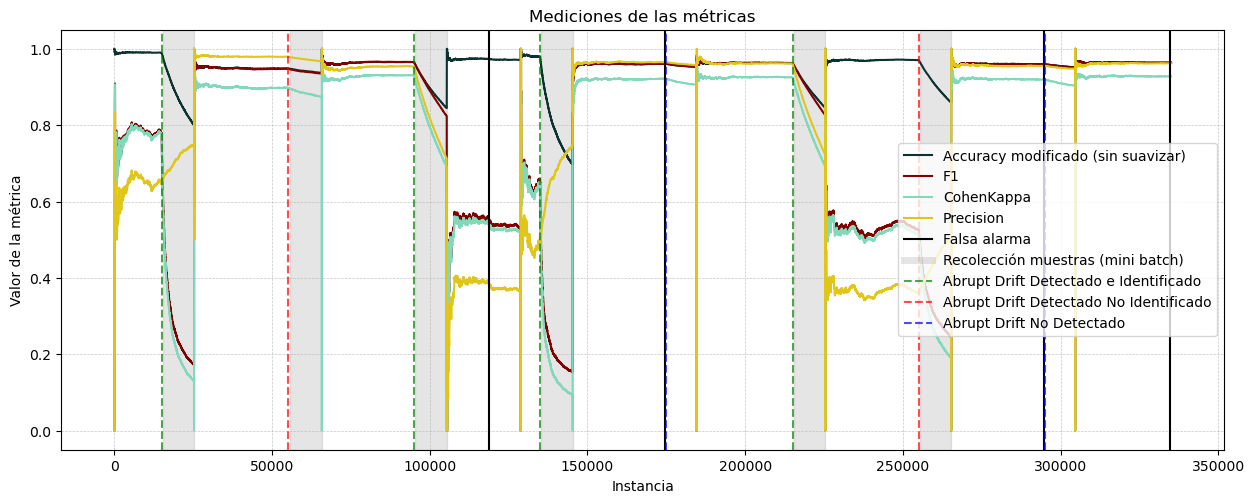

In [30]:
falsas_alarmas, tiempos_deteccion, drifts_detectados_totales, drifts_totales, duracion_total,mediciones_metricas = evaluar_drift( tipo_drift="abrupto", 
    iteracciones=iteracciones_totales, num_drift_iteracion=num_drift_iteracion_totales, imprimir_mensajes=False)

In [40]:
estadisticas(optimizado=True, falsas_alarmas=falsas_alarmas, tiempos_deteccion=tiempos_deteccion, drifts_detectados_totales= drifts_detectados_totales, drifts_totales=drifts_totales, mediciones_metricas= mediciones_metricas, duracion_total = duracion_total, detector= "KSWIN_Modificado", tipo_drift="abrupto")

Falsa alarma en 14999 con tiempo de 336.90065336227417
Falsa alarma en 54599 con tiempo de 197.08177709579468
MTFA: 266.99122
Tiempos de deteccion: 
[1.692340612411499]
[]
MTD: 0.84617
FAR: 0.66667
Drift drift_abrupto en el punto {'punto': 15000, 'detectado': False, 'identificado': False} no detectado
MDR: 0.5
IR: 1.0
Media de la metrica Accuracy: 0.8972284510411563
Media de la metrica F1: 0.777109768912375
Media de la metrica CohenKappa: 0.7446993965361329
Media de la metrica Precision: 0.8248669455273363
Duracion total: 534.7982370853424


### Gradual

In [ ]:
falsas_alarmas, tiempos_deteccion, drifts_detectados_totales, drifts_totales, duracion_total,mediciones_metricas = evaluar_drift( tipo_drift="gradual", 
    iteracciones=iteracciones_totales, num_drift_iteracion=num_drift_iteracion_totales, imprimir_mensajes=False)

KeyboardInterrupt: 

In [65]:
estadisticas(True, falsas_alarmas, tiempos_deteccion, drifts_detectados_totales, drifts_totales, mediciones_metricas, duracion_total, "KSWIN_Modificado", "gradual")

MTFA: 0.0
Tiempos de deteccion: 
[1.096947431564331]
MTD: 1.09695
FAR: 0.0
Drift drift_gradual en el punto {'inicio': 32500, 'fin': 37500, 'detectado': False, 'identificado': False} no detectado
MDR: 0.5
IR: 1.0
Media de la metrica Accuracy: 0.855530874081606
Media de la metrica F1: 0.7299243501196466
Media de la metrica CohenKappa: 0.6668257054934694
Media de la metrica Precision: 0.8466117676809418
Duracion total: 295.2426459789276


### Incremental

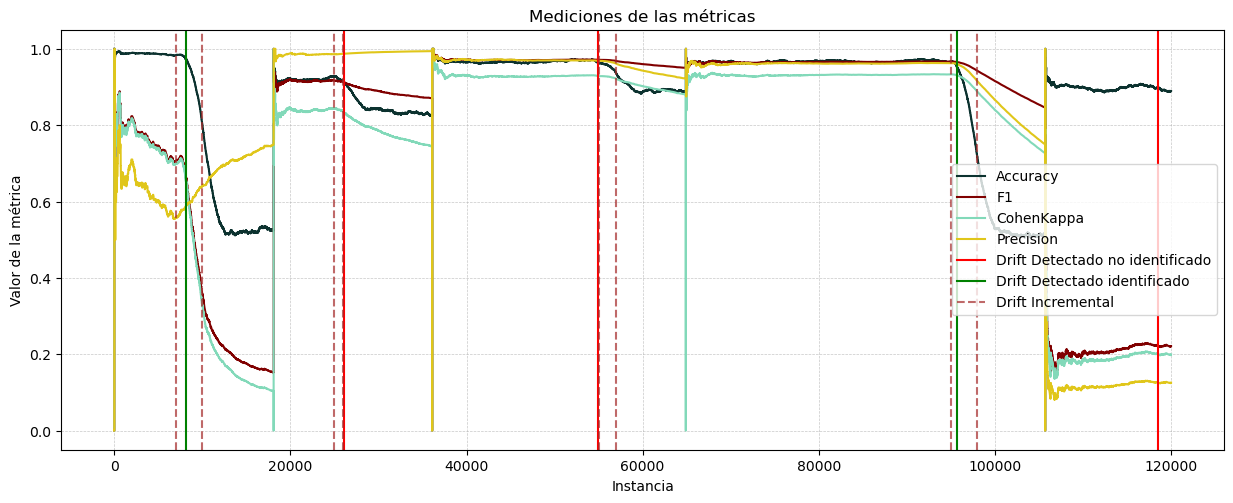

In [ ]:
falsas_alarmas, tiempos_deteccion, drifts_detectados_totales, drifts_totales, duracion_total,mediciones_metricas = evaluar_drift( tipo_drift="incremental", 
    iteracciones=iteracciones_totales, num_drift_iteracion=num_drift_iteracion_totales, imprimir_mensajes=False)

In [58]:
estadisticas(True, falsas_alarmas, tiempos_deteccion, drifts_detectados_totales, drifts_totales, mediciones_metricas, duracion_total, "KSWIN_Modificado", "incremental")

Falsa alarma en 26099 con tiempo de 101.35450291633606
Falsa alarma en 54899 con tiempo de 135.45053696632385
Falsa alarma en 118499 con tiempo de 288.3114755153656
MTFA: 175.03884
Tiempos de deteccion: 
[3.6137712001800537, 2.6248533725738525]
MTD: 6.23862
FAR: 0.6
Drift drift_incremental en el punto {'inicio': 25000, 'fin': 26000, 'detectado': False, 'identificado': False} no detectado
Drift drift_incremental en el punto {'inicio': 55000, 'fin': 57000, 'detectado': False, 'identificado': False} no detectado
MDR: 0.5
IR: 1.0
Media de la metrica Accuracy: 0.8836653090348783
Media de la metrica F1: 0.7890242440310893
Media de la metrica CohenKappa: 0.7423452325151882
Media de la metrica Precision: 0.810963640558521
Duracion total: 529.5103898048401
